In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
# ESIO Imports
import esio

# Issues
## How to deal with model having a smaller "ocean" area than reality and thus always a smaller SIC in winter?
## Also, need to deal with pole "seam" gap (try different methods)

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
# Load in Obs
data_dir = r'/home/disk/sipn/nicway/data/obs/'
fig_dir = r'/home/disk/sipn/nicway/python/ESIO/figures'
da_51 = xr.open_dataarray(os.path.join(data_dir, 'NSIDC_0051/sipn_nc/NSIDC_0051.nc'))
da_79 = xr.open_dataarray(os.path.join(data_dir, 'NSIDC_0079/sipn_nc/NSIDC_0079.nc'))
da_81 = xr.open_dataarray(os.path.join(data_dir, 'NSIDC_0081/sipn_nc/NSIDC_0081.nc'))

In [10]:
# Load in Model
nmme_refor_dir = r'/home/disk/sipn/nicway/data/model/nmme/reforecast/sipn_nc/GFDL_FLORB01_*.nc'
ds_gfdl_flor_in = xr.open_mfdataset(nmme_refor_dir)
ds_gfdl_flor_in.dims

Frozen(SortedKeysDict({'x': 304, 'y': 448, 'ensemble': 12, 'fore_time_i': 12, 'init_time': 408}))

In [11]:
# Mask out areas where 1) no observations, 2) no model
mask_obs = da_51.isnull().sum(dim='time') / da_51.time.size
mask_mod = ds_gfdl_flor_in.sic.isel(fore_time_i=0).isel(init_time=0).isel(ensemble=0).isnull()
mask_comb = (mask_obs<=0.1) & (mask_mod)
# Apply
da_51 = da_51.where(mask_comb)
ds_gfdl_flor = ds_gfdl_flor_in.where(mask_comb)
ds_gfdl_flor.coords['fore_time'] = ds_gfdl_flor_in.fore_time # add back coords that were dropped

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


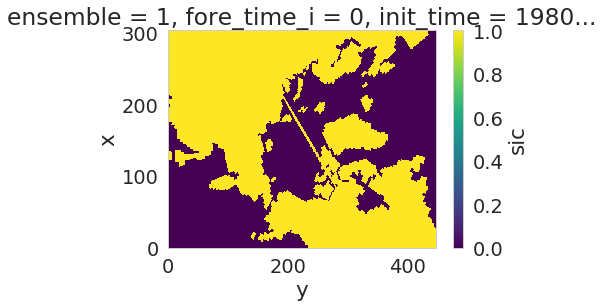

In [35]:
mask_mod.plot()

In [ ]:
WHY IS THERE SO MUCH MISSING??????????????????

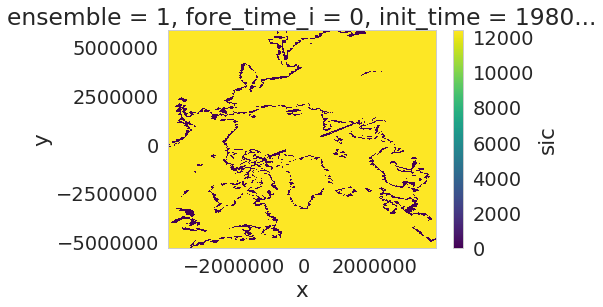

In [42]:
(da_51.isnull().sum(dim='time')).plot()

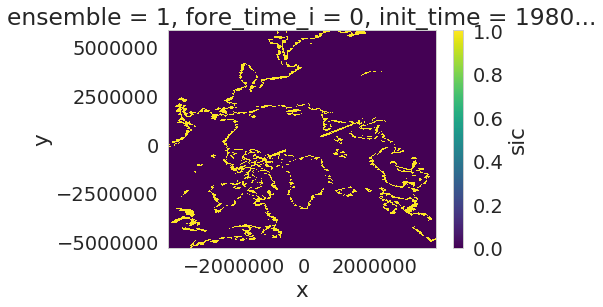

In [37]:
mask_comb.plot()

In [13]:
# Aggregate over domain
da_51_avg = da_51.sum(dim='x').sum(dim='y')*(25*25)/(10**6)
da_79_avg = da_79.sum(dim='x').sum(dim='y')*(25*25)/(10**6)
da_81_avg = da_81.sum(dim='x').sum(dim='y')*(25*25)/(10**6)
ds_gfdl_flor_avg = ds_gfdl_flor.sic.sum(dim='x').sum(dim='y')*(25*25)/(10**6)

In [14]:
# Aggreagate Obs to Model temporal time stamp
# ex: gfdl data is monthly means, time stamp at beinging of period
da_51_avg_mon = da_51_avg.resample(time='MS').mean()
da_79_avg_mon = da_79_avg.resample(time='MS').mean()
da_81_avg_mon = da_81_avg.resample(time='MS').mean()

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


In [15]:
# Trim to common time periods
(ds_obs_out, ds_mod_out) = esio.trim_common_times(da_51_avg_mon, ds_gfdl_flor_avg)

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [16]:
# Format obs like model
da_51_avg_mon_X = esio.format_obs_like_model(ds_mod_out, ds_obs_out)

In [17]:
 # Get observational mean and sigma
(mu, sigma) = esio.clim_mu_sigma(da_51_avg_mon, method='MK')

In [18]:
c_nrmse = esio.NRMSE(ds_gfdl_flor_avg, da_51_avg_mon_X, sigma)

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


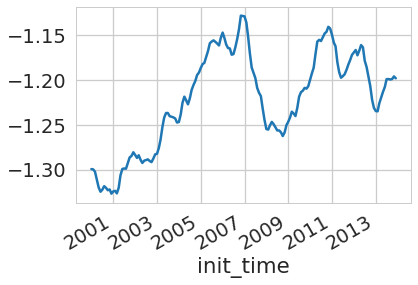

In [19]:
#NRMSE is following the same pattern per months as Hawkins et al. 2016.
c_nrmse.plot()

KeyboardInterrupt: 

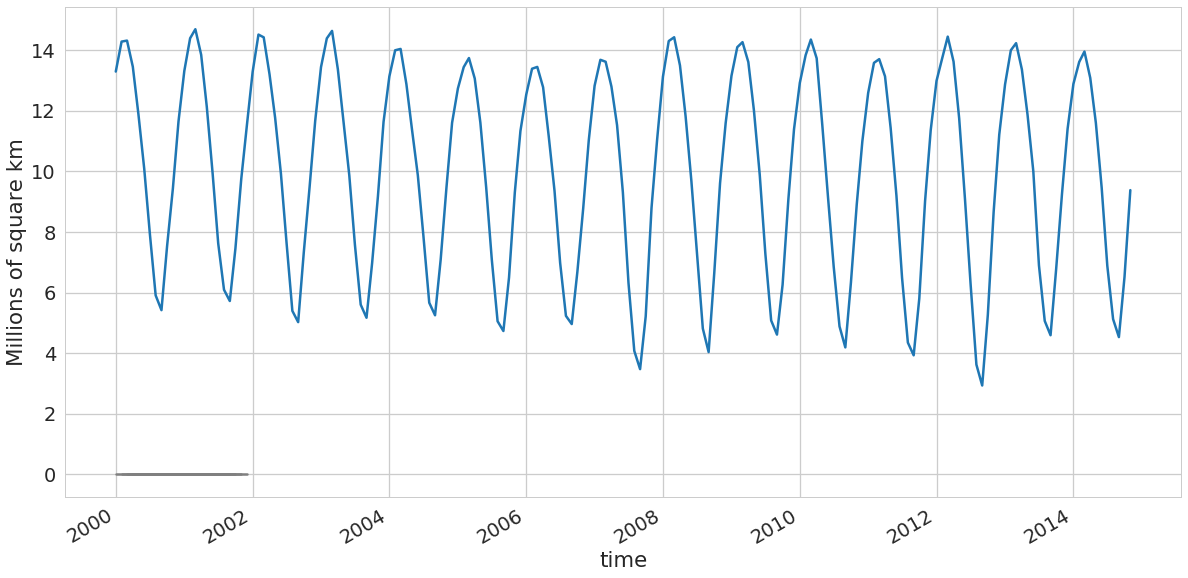

In [21]:
# Plot pan-Arctic sea ice extent
f, ax1 = plt.subplots(1,1)
f.set_size_inches(20, 10)
# Observations
ds_obs_out.plot(ax=ax1, label='NSIDC Bootstrap (Comiso et al. 2017)')
plt.ylabel('Millions of square km')
# Models
esio.plot_model_ensm(ds_mod_out, axin=ax1, labelin='GFDL FLORB01 Model Ensembles')
plt.legend(bbox_to_anchor=(1.03, 1.05))
plt.xlim([ds_gfdl_flor_avg.fore_time.min().values, ds_gfdl_flor_avg.fore_time.max().values])
f.savefig(os.path.join(fig_dir,'panArcticSIC.png'),bbox_inches='tight',dpi=200)

In [ ]:
# Plot pan-Arctic sea ice extent
f, ax1 = plt.subplots(1,1)
f.set_size_inches(20, 10)
# Observations
da_51_avg.plot(ax=ax1, label='NSIDC Historical (Cavalieri et al. 1996)')
da_79_avg.plot(ax=ax1, label='NSIDC Bootstrap (Comiso et al. 2017)')
da_81_avg.plot(ax=ax1, label='NSIDC Near-Real-Time (Maslanik et al. 1999)')
plt.ylabel('Millions of square km')
# Models
# esio.plot_model_ensm(ds_gfdl_flor_avg, axin=ax1, labelin='GFDL FLORB01 Model Ensembles')
plt.legend(bbox_to_anchor=(1.03, 1.05))
f.savefig(os.path.join(fig_dir,'panArcticSIC.png'),bbox_inches='tight',dpi=200)

In [ ]:
# # Plot difference between NSIDC Historical and NRT data set
# plt.figure(figsize=(10,5))
# (da_51_avg-da_81_avg).plot(label='NSIDC Historical - Near Real Time')
# plt.ylabel('Millions of square km')
# plt.legend(bbox_to_anchor=(1.03, 1.05))

In [ ]:
# # Plot pan-Arctic sea ice extent RATE (daily)
# f=plt.figure(figsize=(20,10))
# da_51_avg.diff(dim='time').plot(label='NSIDC Historical (Cavalieri et al. 1996)')
# da_79_avg.diff(dim='time').plot(label='NSIDC Bootstrap (Comiso et al. 2017)')
# da_81_avg.diff(dim='time').plot(label='NSIDC Near-Real-Time (Maslanik et al. 1999)')
# plt.ylabel('Millions of square km\n per day')
# plt.legend(bbox_to_anchor=(1.03, 1.05))
# plt.ylim([-0.4, 0.4])
# f.savefig(os.path.join(fig_dir,'panArcticSIC.png'),bbox_inches='tight',dpi=200)

In [ ]:
# # Plot difference between NSIDC Historical and NRT data set RATES
# plt.figure(figsize=(10,5))
# (da_51_avg.diff(dim='time')-da_81_avg.diff(dim='time')).plot(label='NSIDC Historical - Near Real Time')
# plt.ylabel('Millions of square km')
# plt.legend(bbox_to_anchor=(1.03, 1.05))
# plt.ylim([-0.1, 0.1])

In [25]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'lightgrey')
cmap_dif = matplotlib.colors.ListedColormap(sns.color_palette("RdBu", 10))
cmap_dif.set_bad(color = 'lightgrey')


In [26]:
# Plot coverage on a certain date
cdate = '2013-01-16'
c_sic = ds_gfdl_flor.isel(fore_time_i=0)
c_sic = c_sic.mean(dim='ensemble').sel(init_time=cdate, method='nearest').sic.squeeze()

<xarray.DataArray 'sic' (x: 304, y: 448)>
dask.array<shape=(304, 448), dtype=float64, chunksize=(304, 448)>
Coordinates:
  * y          (y) int64 5850000 5825000 5800000 5775000 5750000 5725000 ...
  * x          (x) int64 -3850000 -3825000 -3800000 -3775000 -3750000 ...
    lon        (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 ...
    lat        (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
    init_time  datetime64[ns] 2013-01-01
    fore_time  datetime64[ns] dask.array<shape=(), chunksize=()>

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


ValueError: zero-size array to reduction operation minimum which has no identity

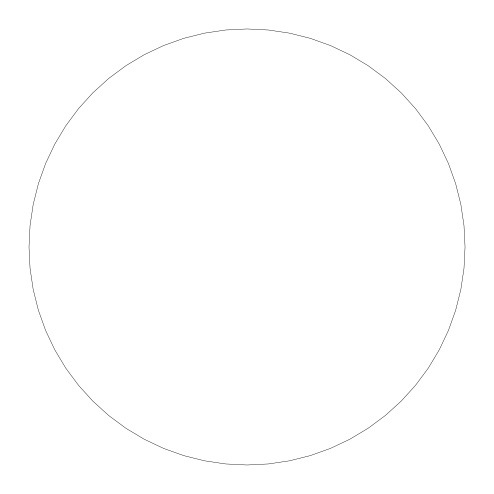

In [27]:
# Plot Obs and model SIC for date
f = plt.figure(figsize=(30,30));

# Model
ax1 = plt.subplot(3, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=0))
c_sic.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic,
                      vmin=0, vmax=1)
ax1.set_title('GFDL')
# Add coastlines and meridians/parallels 
ax1.coastlines(linewidth=0.75, color='black', resolution='50m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())



# Obs NSIDC 0051
ax2 = plt.subplot(3, 1, 2, projection=ccrs.NorthPolarStereo(central_longitude=0))
da_51.sel(time=cdate).plot.pcolormesh(ax=ax2, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic,
                      vmin=0, vmax=1)
ax2.set_title('NSIDC 0051')
# Add coastlines and meridians/parallels 
ax2.coastlines(linewidth=0.75, color='black', resolution='50m')
ax2.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax2.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())



# Model-Obs
ax3 = plt.subplot(3, 1, 3, projection=ccrs.NorthPolarStereo(central_longitude=0))
(c_sic - da_51.sel(time=cdate)).plot.pcolormesh(ax=ax3, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_dif,
                      vmin=-1, vmax=1)
ax3.set_title('GFDL - NSIDC 0051')
# Add coastlines and meridians/parallels 
ax3.coastlines(linewidth=0.75, color='black', resolution='50m')
ax3.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax3.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())


plt.tight_layout()